**MASK WEAR DETECTION WITH LOGISTIC REGRESSION :**

To begin, we import the libraries we need and we redefine the DataSet class to correspond with our aim :

In [13]:
from torch.utils.data import DataLoader
import os
import cv2
import random

class DataSet :

    def __init__(self,root,label):
        """Init function should not do any heavy lifting, but
            must initialize how many items are available in this data set.
        """
        self.ROOT = root
        self.images = read_images(root)
        self.label = torch.from_numpy(np.array(label))

    def __len__(self):
        """return number of elements in our dataset"""
        
        return len(self.images)

    def __getitem__(self, idx):
        """ Here we have to return the item requested by `idx`
            The PyTorch DataLoader class will use this method to make an iterable for
            our training or validation loop.
        """
        img = self.images[idx]
        label = self.label[idx]

        return img, label

We define the read_images function and we build our 2 datasets of mask and unmask people (which they will be redivided in the next to constitute the 3 datasets to create and improve the model) :

In [14]:
import torch
import numpy as np

def read_images(root) :
        '''load all the images from a folder'''
        images = []
        for filename in os.listdir(root) :
            '''
            Python method listdir() returns a list containing the names of the 
            entries in the directory given by path. The list is in arbitrary order. 
            It does not include the special entries '.' and '..' even if they are 
            present in the directory.'''
            img = cv2.imread(os.path.join(root,filename))
            if img is not None:
                img = img[:,:,::-1]/255 # To shuffle the color channels form BGR to RGB and /255 to normalize
                # A REGARDER COMMENT CA MARCHE PLUS EN DETAIL 
                images.append(img)
        return torch.from_numpy(np.array(images))

ds_uwm = DataSet('Um_200',[0 for k in range(200)]) # 200 images in the file
ds_wm = DataSet("Wm_200",[1 for k in range(200)]) # 200 images in the file

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'Um_200'

Here we take only 400 images because we cannot take more with 8Gb of RAM ...

Indeed, let's display the size of the datasets :

In [ ]:
print("Worn Mask Dataset Length : {}\n".format(len(ds_wm)))
print("Unworn Mask Dataset Length : {}".format(len(ds_uwm)))

To see en example, let's show the 6th element of the unworn mask dataset with its type and its shape :

In [ ]:
img, label = ds_uwm[5]
print(img,label)
print("\nType of the image : {}\n".format(type(img)))
print("Shape of the image : {}".format(img.shape))

# Training, Validation and Testing Datasets

We create here our 3 datasets :

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Testing set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import ConcatDataset

train_ds_wm, temp = random_split(ds_wm, [140, 60])
val_ds_wm, test_ds_wm = random_split(temp, [20, 40])

train_ds_uwm, temp = random_split(ds_uwm, [140, 60])
val_ds_uwm, test_ds_uwm = random_split(temp, [20, 40])

train_ds = train_ds_uwm + train_ds_wm
val_ds = val_ds_uwm + val_ds_wm
test_ds = test_ds_uwm + test_ds_wm

Now let's show the length of each dataset :

In [ ]:
print("Length of the training set : {}\n".format(len(train_ds)))
print("Length of the validation set = {}\n".format(len(val_ds)))
print("Length of the testing set = {}\n".format(len(test_ds)))

Then let's initialize the dataloader :

In [3]:
from torch.utils.data import DataLoader

# The most important argument of DataLoader constructor is dataset, which indicates a dataset object to load data from. 
# PyTorch supports two different types of datasets:
#        - map-style datasets,
#        - iterable-style datasets"""

batch_size = 40

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

# We set shuffle=True for the training dataloader, so that the batches generated in each epoch are different, and this 
# randomization helps generalize & speed up the training process. 
# On the other hand, since the validation dataloader is used only for evaluating the model, there is no need to shuffle 
# the images.

NameError: name 'train_ds' is not defined

# Model :

Now that we have prepared our data loaders, we can define our model.

A logistic regression model is almost identical to a linear regression model i.e. there are weights and bias matrices, and the output is obtained using simple matrix operations (pred = x @ w.t() + b).

We can use nn.Linear to create the model instead of defining and initializing the matrices manually.

Since nn.Linear expects the each training example to be a vector, each 1024x1024x3 image tensor needs to be flattened out into a vector of size 3145728 (1024x1024x3), before being passed into the model.

The output for each image is vector of size 2, with each element of the vector signifying the probability a particular target label (i.e. 0 or 1). The predicted label for an image is simply the one with the highest probability.

In [4]:
import torch.nn as nn

input_size = 1024*1024*3
num_classes = 2

# Logistic regression model
model = nn.Linear(input_size, num_classes)

We display here the shape of the model weights and the model weights :

In [5]:
print("Display the shape of the model weights : {}\n".format(model.weight.shape))
print("Display all the model weights : {}\n".format(model.weight))

Display the shape of the model weights : torch.Size([2, 3145728])

Display all the model weights : Parameter containing:
tensor([[ 2.3009e-05,  3.0932e-05, -1.4196e-04,  ...,  1.1263e-04,
          8.4059e-05, -4.8918e-04],
        [-1.5013e-04,  2.1346e-04, -2.5075e-04,  ...,  2.3603e-05,
          5.3030e-04,  2.7577e-04]], requires_grad=True)



In the same way, we display the shape of the model biases and the model biases :

In [6]:
print("Display the shape of the model biases : {}\n".format(model.bias.shape))
print("Display all the model biases : {}\n".format(model.bias))

Display the shape of the model biases : torch.Size([2])

Display all the model biases : Parameter containing:
tensor([9.7260e-06, 5.6241e-04], requires_grad=True)



Let's define our model, by extending the `nn.Module` class from PyTorch.

In [7]:
class MWDModel(nn.Module): # MWD for Mask Wear detection
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 1048576*3)
        out = self.linear(xb)
        return out
    
model = MWDModel()

Here we display the shape of the model linear weights and biases and the model parameters :

In [8]:
print("Shape of the model linear weights : {}\n".format(model.linear.weight.shape))
print("Shape of the model linear biases : {}\n".format(model.linear.bias.shape))
print("Display the model parameters : \n")
list(model.parameters())

Shape of the model linear weights : torch.Size([2, 3145728])

Shape of the model linear biases : torch.Size([2])

Display the model parameters : 



[Parameter containing:
 tensor([[-2.7742e-04,  3.8093e-04, -1.7255e-04,  ...,  4.6775e-04,
          -4.6043e-04,  3.6522e-04],
         [ 1.7035e-04,  1.2365e-04, -7.0131e-05,  ...,  3.2752e-04,
          -5.2368e-04, -2.5430e-04]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0005, -0.0002], requires_grad=True)]

In [9]:
for images, labels in train_loader:
    outputs = model(images.float()) # FLOAT()
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

# When the error is RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #4 'mat1', you 
# would need to use the .float() function since it says Expected object of scalar type Float.

# Therefore, the solution is changing y_pred = model(X_trainTensor) to y_pred = model(X_trainTensor.float()).

# Likewise, when you get another error for loss = loss_fn(y_pred, y_trainTensor), you need y_trainTensor.long() since the 
# error message says Expected object of scalar type Long.

# You could also do model.double()'''

NameError: name 'train_loader' is not defined

We import here the softmax function, which is included in the torch.nn.functional package, and requires us to specify a dimension along which the softmax must be applied.

In [10]:
import torch.nn.functional as F

Here we transform our outputs into probabilities with the softmax function :

In [11]:
probs = F.softmax(outputs, dim=1)

print("Look at sample probabilities :")
print("Sample probabilities:\n", probs[:2].data)

NameError: name 'outputs' is not defined

Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. 

This is done using `torch.max`, which returns the largest element and the index of the largest element along a particular dimension of a tensor.

Let's show the predicted labels for the first batch of training images.

In [12]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

NameError: name 'probs' is not defined

Here are the actual labels.

In [16]:
labels.long()

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1])

# Evaluation Metric and Loss Function :

We have to evaluate how well our model is performing. 

A natural way to do this would be to find the percentage of labels that were predicted correctly i.e. the **accuracy** of the predictions. 

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels.long()).item() / len(preds))

Let's calculate the accuracy of the current model, on the first batch of data. 

In [18]:
accuracy(outputs, labels.long())

tensor(0.4250)

*While the accuracy is a great way for us (humans) to evaluate the model, it can't be used as a loss function for optimizing our model using gradient descent, for the following reasons:*

1. **It's not a differentiable function.** `torch.max` and `==` are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. **It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.** 

Due to these reasons, accuracy is a great **evaluation metric** for classification, but not a good loss function. A commonly used loss function for classification problems is the **cross entropy**, which has the following formula:

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

While it looks complicated, it's actually quite simple:

* For each output row, pick the predicted probability for the correct label. E.g. if the predicted probabilities for an image are `[0.1, 0.3, 0.2, ...]` and the correct label is `1`, we pick the corresponding element `0.3` and ignore the rest.

* Then, take the [logarithm](https://en.wikipedia.org/wiki/Logarithm) of the picked probability. If the probability is high i.e. close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function that also provides good feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). This makes it a good choice for the loss function. 

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross entropy as part of the `torch.nn.functional` package. Moreover, it also performs softmax internally, so we can directly pass in the outputs of the model without converting them into probabilities.

In [19]:
loss_fn = F.cross_entropy

Let's calculate the cross entropy of the current model, on the first batch of data :

In [20]:
# Loss for current batch of data
loss = loss_fn(outputs, labels.long())
print(loss)
print(type(outputs))

tensor(0.7155, grad_fn=<NllLossBackward>)
<class 'torch.Tensor'>


## Training the model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem. Let's impelment the problem-specific parts within our `MnistModel` class:

In [21]:
class MWDModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 1048576*3)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images.float())                  # Generate predictions
        loss = F.cross_entropy(out, labels.long()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images.float())                    # Generate predictions
        loss = F.cross_entropy(out, labels.long())   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MWDModel()

Now we'll define an `evaluate` function, which will perform the validation phase, and a `fit` function which will perform the entire training process.

The `fit` function records the validation loss and metric from each epoch and returns a history of the training process. This is useful for debuggin & visualizing the training process.

**Configurations like batch size, learning rate etc. need to picked in advance while training machine learning models, and are called hyperparameters.** Picking the right hyperparameters is critical for training an accurate model within a reasonable amount of time, and is an active area of research and experimentation. Therefore we have to try different learning rates and see how it affects the training process.

In [22]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we train the model, let's see how the model performs on the validation set with the initial set of randomly initialized weights & biases.

In [23]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 0.6966473460197449, 'val_acc': 0.5}

The initial accuracy is around 50%, which is what one might expect from a randomly intialized model (since it has 1 chance over 2 of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for 8 epochs and look at the results :

In [24]:
history = fit(10, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 735.9677, val_acc: 0.5000
Epoch [1], val_loss: 1430.6223, val_acc: 0.5000
Epoch [2], val_loss: 0.0000, val_acc: 1.0000
Epoch [3], val_loss: 2.3949, val_acc: 0.9750
Epoch [4], val_loss: 0.0000, val_acc: 1.0000
Epoch [5], val_loss: 0.0000, val_acc: 1.0000
Epoch [6], val_loss: 0.0000, val_acc: 1.0000
Epoch [7], val_loss: 0.0000, val_acc: 1.0000
Epoch [8], val_loss: 0.0000, val_acc: 1.0000
Epoch [9], val_loss: 0.0000, val_acc: 1.0000


Let's loot at the behavior of the loss during the evolution of the epoch :

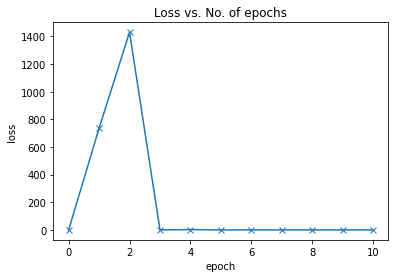

In [25]:
import matplotlib.pyplot as plt

history = [result0] + history
loss = [result['val_loss'] for result in history]
plt.plot(loss, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

Let's loot at the behavior of the accuracy during the evolution of the epoch :

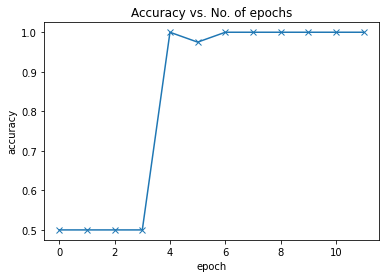

In [26]:

history = [result0] + history
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

# See how it works with the testing set :

Let's look at the overall loss and accuracy of the model on the test set :

In [36]:
test_loader = DataLoader(test_ds, batch_size=80)
result = evaluate(model, test_loader)
result

{'val_loss': 4.379721164703369, 'val_acc': 0.9750000238418579}

# Testing with individual images :

In [30]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Let's try now with images of masked or unmasked people taken on the internet :

In [33]:
new_imgs = read_images("Individual_tests_internet")

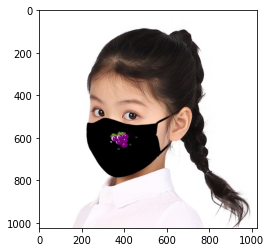

Predicted: 0


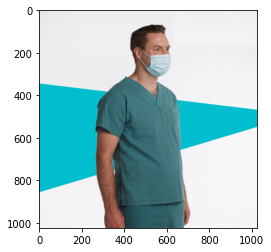

Predicted: 0


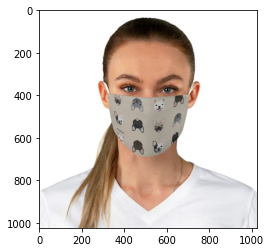

Predicted: 0


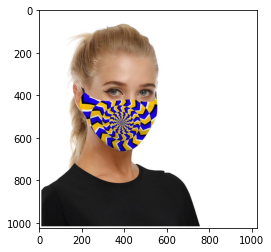

Predicted: 0


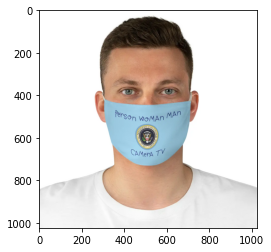

Predicted: 0


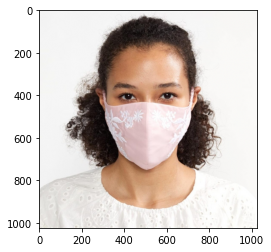

Predicted: 0


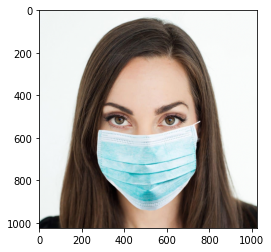

Predicted: 1


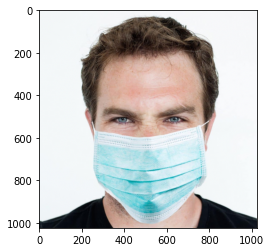

Predicted: 1


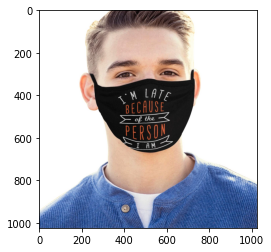

Predicted: 0


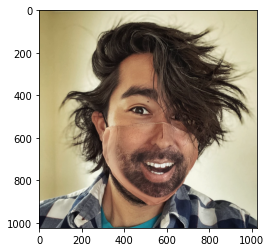

Predicted: 0


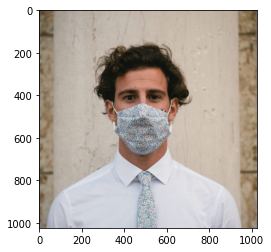

Predicted: 1


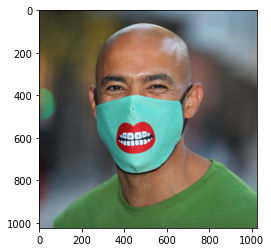

Predicted: 0


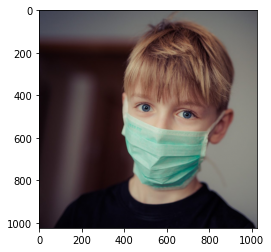

Predicted: 1


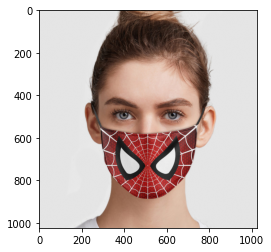

Predicted: 0


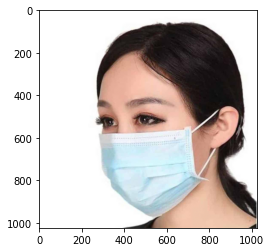

Predicted: 1


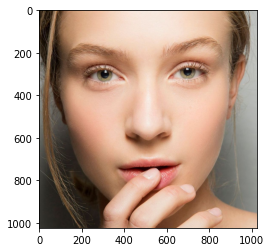

Predicted: 0


In [35]:
for i in range(len(new_imgs)) :
    plt.imshow(new_imgs[i])
    plt.show()
    print('Predicted:', predict_image(new_imgs[i].float(), model))

**We see the main bias of our model : we can detect only surgical type blue masks !**